# MoneyBall Reloaded

## DATA PROCESSING 

### Import

In [1]:
import pandas as pd
from unidecode import unidecode
import numpy as np
import matplotlib
import time
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib.patches as patches
import warnings
import sklearn
from sklearn.datasets import make_blobs
from sklearn_extensions.fuzzy_kmeans import FuzzyKMeans
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from scipy.spatial import distance
csv_files_location = "./csv/"
start_time = time.time()

/home/elie/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# retrieve the basic stats
df_2016 = pd.read_csv(csv_files_location+'NBA_totals_2015-2016.csv')
df_2017 = pd.read_csv(csv_files_location+'NBA_totals_2016-2017.csv')
df_2018 = pd.read_csv(csv_files_location+'NBA_totals_2017-2018.csv')
df_2019 = pd.read_csv(csv_files_location+'NBA_totals_2018-2019.csv')
df_2020 = pd.read_csv(csv_files_location+'NBA_totals_2019-2020.csv')

### We normalize every names (no 'Sr', 'III', 'Sr', '.', foreign accents or characters)

In [3]:
def clean_names(df, col_name):
    df[col_name] = df[col_name].apply(str.replace, args=[" Jr.", ""])
    df[col_name] = df[col_name].apply(str.replace, args=[" Sr.", ""])
    df[col_name] = df[col_name].apply(str.replace, args=[" III", ""])
    df[col_name] = df[col_name].apply(str.replace, args=[" II", ""])
    df[col_name] = df[col_name].apply(unidecode)
    df[col_name] = df[col_name] = df[col_name].apply(str.replace, args=[".", ""])
    return df


### Let's clean all our df

In [4]:
df_2016 = clean_names(df_2016, "Player")
df_2017 = clean_names(df_2017, "Player")
df_2018 = clean_names(df_2018, "Player")
df_2019 = clean_names(df_2019, "Player")
df_2020 = clean_names(df_2020, "Player")

### Let's retrieve the final team of players who have been traded during the season
### Two Birds One Rock: We both get the name as well as removing the retired players (as the 2020 season starts)

In [5]:
team_and_player = df_2020.loc[:, ["Player", "Tm", 'Pos']]
team_and_player["final_team"] = team_and_player.groupby('Player')['Tm'].transform('last')
team_and_player = team_and_player[["Player", "final_team", "Pos"]]
team_and_player = team_and_player.drop_duplicates(subset=['Player'])

### Remove the TOT lines for players who have been traded during the season

In [6]:
df_2016 = df_2016[df_2016["Tm"] != "TOT"]
df_2017 = df_2017[df_2017["Tm"] != "TOT"]
df_2018 = df_2018[df_2018["Tm"] != "TOT"]
df_2019 = df_2019[df_2019["Tm"] != "TOT"]
df_2020 = df_2020[df_2020["Tm"] != "TOT"]

### Let's only keep the column we are interested in

In [7]:
basic_stats_2016 = df_2016.loc[:, ['Player', 'G', 'MP', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] ]
basic_stats_2017 = df_2017.loc[:, ['Player', 'G', 'MP', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] ]
basic_stats_2018 = df_2018.loc[:, ['Player', 'G', 'MP', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] ]
basic_stats_2019 = df_2019.loc[:, ['Player', 'G', 'MP', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] ]
basic_stats_2020 = df_2020.loc[:, ['Player', 'G', 'MP', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] ]

### Concat every df and group by player name

In [8]:
basic_stats = basic_stats_2016.append(basic_stats_2017).append(basic_stats_2018).append(basic_stats_2019).append(basic_stats_2020) 
summed_basic_stats = basic_stats.groupby(['Player']).sum()

### Let's remove those who have played less than 100 games or 2500 minutes

In [9]:
summed_basic_stats = summed_basic_stats.loc[ (summed_basic_stats['G'] > 100) | (summed_basic_stats['MP'] > 2500) ]

In [10]:
avg_stats = summed_basic_stats.loc[:,(summed_basic_stats.columns != "Player") & (summed_basic_stats.columns != "G")].div(summed_basic_stats["G"], axis=0)
avg_stats = avg_stats.apply(round, args=[1])

### Per 36 minutes

In [11]:
avg_stats_36_minutes = avg_stats.div((avg_stats["MP"]/36) , axis=0)
avg_stats_36_minutes = avg_stats_36_minutes.apply(round, args=[1])
names = pd.DataFrame(avg_stats_36_minutes.index)

### Scaling

In [12]:
avg_stats_36_minutes = avg_stats_36_minutes - avg_stats_36_minutes.min()
avg_stats_36_minutes = avg_stats_36_minutes / ( avg_stats_36_minutes.max() - avg_stats_36_minutes.min() )
avg_stats_36_minutes = avg_stats_36_minutes.apply(round, args=[2])
avg_stats_36_minutes_scaled = avg_stats_36_minutes.drop(columns=["MP"])
avg_stats_36_minutes_scaled

,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,
Aaron Brooks,0.51,0.44,0.50,0.30,0.41,0.12,0.13,0.12,0.07,0.06,0.49,0.38,0.08,0.51,0.53,0.34
Aaron Gordon,0.52,0.28,0.39,0.46,0.48,0.26,0.31,0.35,0.45,0.41,0.25,0.33,0.22,0.30,0.22,0.42
Aaron Holiday,0.48,0.40,0.48,0.27,0.37,0.17,0.16,0.04,0.16,0.10,0.44,0.48,0.11,0.35,0.31,0.34
Abdel Nader,0.33,0.34,0.44,0.21,0.25,0.16,0.20,0.08,0.27,0.21,0.07,0.38,0.25,0.28,0.39,0.27
Al Horford,0.48,0.28,0.34,0.49,0.47,0.12,0.13,0.33,0.47,0.41,0.43,0.29,0.39,0.28,0.18,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yogi Ferrell,0.39,0.38,0.48,0.24,0.29,0.17,0.15,0.06,0.17,0.11,0.35,0.38,0.06,0.26,0.22,0.31
Zach Collins,0.29,0.20,0.29,0.27,0.32,0.15,0.17,0.45,0.42,0.42,0.12,0.14,0.39,0.37,0.61,0.23
Zach LaVine,0.76,0.46,0.54,0.56,0.62,0.40,0.41,0.08,0.22,0.15,0.34,0.38,0.08,0.56,0.24,0.64


### Retrieve the advanced stats

In [13]:
ad_2016 = pd.read_csv(csv_files_location+'NBA_advanced_2015-2016.csv')
ad_2017 = pd.read_csv(csv_files_location+'NBA_advanced_2016-2017.csv')
ad_2018 = pd.read_csv(csv_files_location+'NBA_advanced_2017-2018.csv')
ad_2019 = pd.read_csv(csv_files_location+'NBA_advanced_2018-2019.csv')
ad_2020 = pd.read_csv(csv_files_location+'NBA_advanced_2019-2020.csv')

### Clean the names

In [14]:
ad_2016 = clean_names(ad_2016, "Player")
ad_2017 = clean_names(ad_2017, "Player")
ad_2018 = clean_names(ad_2018, "Player")
ad_2019 = clean_names(ad_2019, "Player")
ad_2020 = clean_names(ad_2020, "Player")

### Remove the TOT lines for players who have been traded during the season

In [15]:
ad_2016 = ad_2016[ad_2016["Tm"] != "TOT"]
ad_2017 = ad_2017[ad_2017["Tm"] != "TOT"]
ad_2018 = ad_2018[ad_2018["Tm"] != "TOT"]
ad_2019 = ad_2019[ad_2019["Tm"] != "TOT"]
ad_2020 = ad_2020[ad_2020["Tm"] != "TOT"]

### Let's only keep the column we are interested in

In [16]:
ad_2016 = ad_2016.loc[:, ["Player", "G", "MP", "PER", "TS%", "3PAr", "TRB%", "USG%", "OWS", "DWS"] ]
ad_2017 = ad_2017.loc[:, ["Player", "G", "MP", "PER", "TS%", "3PAr", "TRB%", "USG%", "OWS", "DWS"] ]
ad_2018 = ad_2018.loc[:, ["Player", "G", "MP", "PER", "TS%", "3PAr", "TRB%", "USG%", "OWS", "DWS"] ]
ad_2019 = ad_2019.loc[:, ["Player", "G", "MP", "PER", "TS%", "3PAr", "TRB%", "USG%", "OWS", "DWS"] ]
ad_2020 = ad_2020.loc[:, ["Player", "G", "MP", "PER", "TS%", "3PAr", "TRB%", "USG%", "OWS", "DWS"] ]

### For the advanced stats we need to weight a season stats by the number of played games

In [17]:
def ponderateByGamesPlayed(df):
    #On recupere les noms, minutes jouées et matches joués
    names = df["Player"]
    minutes = df["MP"]
    games = df["G"]
    
    # on enleve les noms, minutes jouées et matches joués
    df = df.drop(columns=["Player", "MP", "G"])
    
    # on multiplie chaque stats de chaque joueur par le nb de matches joués pendant cette saison
    df = df.mul(games, axis=0)
    
    # on rajoute les noms, les minutes et des matches joués
    res = pd.concat([names, games, minutes, df], axis=1)
    
    # on rajoute le nom des colonnes
    res.columns = ["Player", "G", "MP", "PER", "TS%", "3PAr", "TRB%", "USG%", "OWS", "DWS"]
    return res

In [18]:
ad_2016 = ponderateByGamesPlayed(ad_2016)
ad_2017 = ponderateByGamesPlayed(ad_2017)
ad_2018 = ponderateByGamesPlayed(ad_2018)
ad_2019 = ponderateByGamesPlayed(ad_2019)
ad_2020 = ponderateByGamesPlayed(ad_2020)

### Concat

In [19]:
summed_ad = ad_2016.append(ad_2017).append(ad_2018).append(ad_2019).append(ad_2020)

### Aggregate

In [20]:
agr = {'MP':['sum'],'G': ['sum'], 'PER':['sum'],'TS%':['sum'],'3PAr':['sum'],'TRB%':['sum'],'USG%':['sum'], 'OWS':['sum'], 'DWS':['sum']}
agg_advanced =summed_ad.groupby(['Player']).agg(agr)

### Let's remove those who have played less than 100 games or 2500 minutes

In [21]:
agg_advanced = agg_advanced.loc[(agg_advanced["MP"]["sum"] > 2500) | (agg_advanced["G"]["sum"] > 100)]

### We now want to retrieve the players height 
### We did it in the csv/players_height.csv file

In [22]:
heights = pd.read_csv(csv_files_location+"players_height.csv")
heights = clean_names(heights, "Name")
heights = heights[["Name", "Height (cm)"]]
heights = heights.rename(columns={"Name": "Player"})

### Let's average by games

In [23]:
games = agg_advanced["G"]["sum"]
final_advanced = agg_advanced.div((games) , axis=0)
final_advanced = final_advanced.drop(columns=["G"])
final_advanced = final_advanced.apply(round, args=[2])
final_advanced = pd.concat([games, final_advanced], axis=1)

### We add the players height

In [24]:
final_advanced = pd.merge(final_advanced, heights, on="Player")
final_advanced = final_advanced.set_index("Player")

### Rename the Columns

In [25]:
final_advanced.columns = ["G", "MP", "PER", "TS%", "3PAr", "TRB%", "USG%", "OWS", "DWS", "Height"]

### Scaling

In [26]:
final_advanced_scaled = final_advanced - final_advanced.min()
final_advanced_scaled = final_advanced_scaled / ( final_advanced_scaled.max() - final_advanced_scaled.min() )
final_advanced_scaled

,G,MP,PER,TS%,3PAr,TRB%,USG%,OWS,DWS,Height
Player,,,,,,,,,,
Aaron Gordon,0.855219,0.765882,0.431565,0.307692,0.397436,0.404936,0.421756,0.307458,0.455577,0.578947
Aaron Holiday,0.047138,0.387580,0.258582,0.269231,0.551282,0.090951,0.397710,0.180365,0.266541,0.157895
Al Horford,0.858586,0.800857,0.545698,0.461538,0.384615,0.403108,0.359542,0.464231,0.652174,0.631579
Al-Farouq Aminu,0.703704,0.707709,0.275524,0.307692,0.628205,0.445155,0.207252,0.265601,0.485822,0.578947
Alec Burks,0.555556,0.445039,0.346857,0.307692,0.435897,0.265996,0.477863,0.201674,0.183365,0.473684
...,...,...,...,...,...,...,...,...,...,...
Willy Hernangomez,0.360269,0.204497,0.617922,0.500000,0.115385,0.760055,0.446947,0.258752,0.190926,0.736842
Wilson Chandler,0.434343,0.688437,0.226928,0.346154,0.589744,0.312614,0.240458,0.272451,0.209830,0.578947
Yogi Ferrell,0.494949,0.418986,0.275970,0.346154,0.576923,0.091408,0.307634,0.240487,0.181474,0.157895


### Let's merge the basic stats, the advanced one and the players name

In [27]:
final = pd.merge(final_advanced_scaled, avg_stats_36_minutes_scaled, on="Player")
final = pd.merge(team_and_player, final, on="Player")
final

,Player,final_team,Pos,G,MP,PER,TS%,3PAr,TRB%,USG%,...,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Steven Adams,OKC,C,0.932660,0.749465,0.547035,0.615385,0.000000,0.542505,0.233206,...,0.34,0.88,0.39,0.56,0.09,0.43,0.33,0.30,0.31,0.32
1,Bam Adebayo,MIA,PF,0.407407,0.603141,0.537673,0.576923,0.025641,0.589122,0.301908,...,0.43,0.55,0.62,0.60,0.35,0.38,0.36,0.47,0.35,0.35
2,LaMarcus Aldridge,SAS,C,0.851852,0.851892,0.711547,0.423077,0.089744,0.482176,0.629389,...,0.43,0.55,0.46,0.48,0.15,0.19,0.39,0.28,0.20,0.63
3,Jarrett Allen,BRK,C,0.404040,0.557459,0.576906,0.730769,0.051282,0.596892,0.230916,...,0.40,0.69,0.62,0.66,0.11,0.19,0.58,0.30,0.37,0.36
4,Al-Farouq Aminu,ORL,PF,0.703704,0.707709,0.275524,0.307692,0.628205,0.445155,0.207252,...,0.17,0.27,0.55,0.46,0.11,0.48,0.22,0.23,0.20,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Trae Young,ATL,PG,0.131313,0.861527,0.624610,0.423077,0.525641,0.130713,0.820992,...,0.70,0.12,0.20,0.15,0.90,0.38,0.06,0.95,0.10,0.79
332,Cody Zeller,CHO,C,0.582492,0.562099,0.492644,0.576923,0.064103,0.504570,0.270992,...,0.38,0.59,0.47,0.52,0.14,0.43,0.33,0.26,0.53,0.33
333,Tyler Zeller,SAS,C,0.279461,0.162027,0.402140,0.384615,0.051282,0.502285,0.352290,...,0.29,0.61,0.44,0.50,0.12,0.10,0.31,0.26,0.59,0.37
334,Ante Zizic,CLE,C,0.037037,0.170236,0.560410,0.730769,0.000000,0.580896,0.327099,...,0.37,0.65,0.53,0.58,0.09,0.10,0.31,0.33,0.51,0.40


## Ploting

In [28]:
PlayerStats="MP"

NormalizeData = pd.read_csv("./csv/players_stats.csv", delimiter =",");

### Ploting Polygone for one player

In [29]:
def performance_polygon(PlayerName):
    Player=10*NormalizeData[NormalizeData.Player.eq(PlayerName)]

    # Player = AdDisp[AdDisp.Year.eq(2020)]

    properties = ['Offensive Win share', 'Defensive win share', 'AST','TS%', "TRB%", "PTS", "3PA", ]
    values = np.random.uniform(5,9,len(properties))

    values = [Player['OWS'], Player['DWS'], Player['AST'], Player["TS%"], Player["TRB%"], Player["PTS"], Player["3PA"]]
    matplotlib.rc('axes', facecolor = 'white')

    fig = plt.figure(figsize=(10,8), facecolor='white')

    axes = plt.subplot(111, polar=True)

    t = np.arange(0,2*np.pi,2*np.pi/len(properties))
    plt.xticks(t, [])

    points = [(x,y) for x,y in zip(t,values)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + \
            [path.Path.LINETO,]*(len(values) -1) + \
            [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color='blue', linewidth=0, alpha=.1)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    plt.scatter(points[:,0],points[:,1], linewidth=2,
                s=50, color='white', edgecolor='black', zorder=10)
    """
    maxi = max([Player.iloc[0,19]+1, Player.iloc[0,20]+1, Player.iloc[0,21]+1])
    if maxi < 10:
        plt.ylim(0,10)
    else:
        plt.ylim(0,maxi)
        """
    plt.ylim(0,10)
    for i in range(len(properties)):
        angle_rad = i/float(len(properties))*2*np.pi
        angle_deg = i/float(len(properties))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 10.75, properties[i], size=14,
                 horizontalalignment=ha, verticalalignment="center")

    plt.title("Statistics of "+PlayerName)
    plt.show()

### Ploting Polygones for multiple players and for certain criterias

In [30]:
def performance_polygon_vs_player(PlayersName, criterias):
    #properties = ['Offensive Win share', 'Defensive win share', 'AST','TS%', "TRB", "PTS", "3PA" ]
    values = np.random.uniform(5,9,len(criterias))
    colors = ["blue", "red", "green", "orange", "brown", "deeppink","sienna",
              "gold", "olivedrab", "mediumspringgreen", "navy", "plum", "cadetblue", "darkmagenta"]
    fig = plt.figure(figsize=(10,8), facecolor='white')
    for i in range (0,len(PlayersName)):
        Player=10*NormalizeData[NormalizeData.Player.eq(PlayersName[i])]
        #Player2=10*NormalizeData[NormalizeData.Player.eq(PlayerName[1])]
        
        # Player = AdDisp[AdDisp.Year.eq(2020)]
    

        values1 = [Player[item] for item in criterias]
        #values1 = [Player['OWS'], Player['DWS'], Player['AST'], Player["TS%"], Player["TRB"], Player["PTS"], Player["3PA"]]
        #values2 = [Player2['OWS'], Player2['DWS'], Player2['AST'], Player2["TS%"], Player2["TRB%"], Player2["PTS"], Player2["3PA"]]
        matplotlib.rc('axes', facecolor = 'white')

        axes = plt.subplot(111, polar=True)
        
        t = np.arange(0,2*np.pi,2*np.pi/len(criterias))
        plt.xticks(t, [])
    
        points = [(x,y) for x,y in zip(t,values1)]
        points.append(points[0])
        points = np.array(points, dtype=object)
        codes = [path.Path.MOVETO,] + \
                [path.Path.LINETO,]*(len(values) -1) + \
                [ path.Path.CLOSEPOLY ]
        _path = path.Path(points, codes)
        _patch = patches.PathPatch(_path, fill=False, color=colors[i], linewidth=0, alpha=.2)
        axes.add_patch(_patch)
        _patch = patches.PathPatch(_path, fill=False, edgecolor=colors[i], linewidth = 2, label=PlayersName[i])
        axes.add_patch(_patch)
        plt.scatter(points[:,0],points[:,1], linewidth=2,
                s=50, color='white', edgecolor='black', zorder=10)
    #plt.scatter(points[:,0],points[:,1], linewidth=2,s=50, color='white', edgecolor='black', zorder=10)
    plt.legend(loc="lower right",borderaxespad=-6)
    """
    maxi = max([Player.iloc[0,19]+1, Player.iloc[0,20]+1, Player.iloc[0,21]+1])
    if maxi < 10:
        plt.ylim(0,10)
    else:
        plt.ylim(0,maxi)
        """
    plt.ylim(0,10)
    for i in range(len(criterias)):
        angle_rad = i/float(len(criterias))*2*np.pi
        angle_deg = i/float(len(criterias))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 10.75, criterias[i], size=14,
                 horizontalalignment=ha, verticalalignment="center")

    plt.title("Performance polygon", pad = 50)
    plt.savefig("polygone")
    plt.show()

### Example

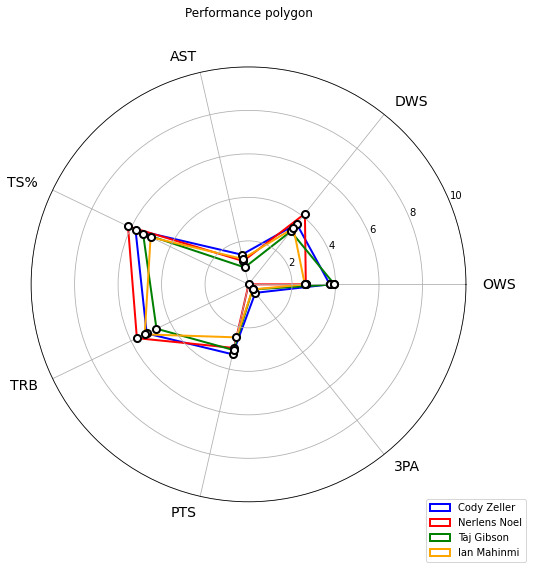

In [31]:
properties = ['OWS', 'DWS', 'AST','TS%', "TRB", "PTS", "3PA" ]
list_of_player = ["Cody Zeller", "Nerlens Noel", "Taj Gibson", "Ian Mahinmi"]
# ignore warnings for the polygone display
warnings.filterwarnings("ignore")
%matplotlib inline
performance_polygon_vs_player(list_of_player, properties)

## CLUSTERING

In [32]:
df = final
player_names = df["Player"]
clustering_df = df.drop(columns=["Player", "final_team","Pos"])
results = pd.DataFrame(data = None, columns = ['epsilon' , 'min_size', 'score'],dtype=np.float64) 
df

,Player,final_team,Pos,G,MP,PER,TS%,3PAr,TRB%,USG%,...,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Steven Adams,OKC,C,0.932660,0.749465,0.547035,0.615385,0.000000,0.542505,0.233206,...,0.34,0.88,0.39,0.56,0.09,0.43,0.33,0.30,0.31,0.32
1,Bam Adebayo,MIA,PF,0.407407,0.603141,0.537673,0.576923,0.025641,0.589122,0.301908,...,0.43,0.55,0.62,0.60,0.35,0.38,0.36,0.47,0.35,0.35
2,LaMarcus Aldridge,SAS,C,0.851852,0.851892,0.711547,0.423077,0.089744,0.482176,0.629389,...,0.43,0.55,0.46,0.48,0.15,0.19,0.39,0.28,0.20,0.63
3,Jarrett Allen,BRK,C,0.404040,0.557459,0.576906,0.730769,0.051282,0.596892,0.230916,...,0.40,0.69,0.62,0.66,0.11,0.19,0.58,0.30,0.37,0.36
4,Al-Farouq Aminu,ORL,PF,0.703704,0.707709,0.275524,0.307692,0.628205,0.445155,0.207252,...,0.17,0.27,0.55,0.46,0.11,0.48,0.22,0.23,0.20,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Trae Young,ATL,PG,0.131313,0.861527,0.624610,0.423077,0.525641,0.130713,0.820992,...,0.70,0.12,0.20,0.15,0.90,0.38,0.06,0.95,0.10,0.79
332,Cody Zeller,CHO,C,0.582492,0.562099,0.492644,0.576923,0.064103,0.504570,0.270992,...,0.38,0.59,0.47,0.52,0.14,0.43,0.33,0.26,0.53,0.33
333,Tyler Zeller,SAS,C,0.279461,0.162027,0.402140,0.384615,0.051282,0.502285,0.352290,...,0.29,0.61,0.44,0.50,0.12,0.10,0.31,0.26,0.59,0.37
334,Ante Zizic,CLE,C,0.037037,0.170236,0.560410,0.730769,0.000000,0.580896,0.327099,...,0.37,0.65,0.53,0.58,0.09,0.10,0.31,0.33,0.51,0.40


### Let's figure out the optimal value for DBSCAN and PCA parameters
### e.g those with the silhouette score closest to 1

In [33]:
for var_portion in np.arange(start = 0.6,stop=0.95,step=0.05,dtype=np.float64):
    pca = PCA(n_components=var_portion, svd_solver = 'full')
    pcabis = pca.fit(clustering_df)
    reducedDataSet = pcabis.transform(clustering_df)
    for eps in np.arange(start = 0.05,stop=0.95,step=0.01,dtype=np.float64):
        for size in np.arange(start = 2,stop=10,step=1,dtype=np.float64): 
            m = DBSCAN(eps=eps, min_samples=size)
            m.fit(reducedDataSet)
            if(max(m.labels_)>1):
                score = sklearn.metrics.silhouette_score(clustering_df,m.labels_)
                results = results.append({'var_portion' : var_portion, 'epsilon' : eps , 'min_size' : size , 'score' : score, 'nb_clusters' : max(m.labels_)+1}, ignore_index=True)

results = results.sort_values(by=[ "score"], ascending = False)

In [34]:
results

,epsilon,min_size,score,nb_clusters,var_portion
781,0.55,2.0,0.257136,3.0,0.85
113,0.27,3.0,0.241859,3.0,0.60
115,0.28,3.0,0.241859,3.0,0.60
111,0.26,3.0,0.241859,3.0,0.60
104,0.23,3.0,0.232994,3.0,0.60
...,...,...,...,...,...
784,0.22,2.0,-0.390143,10.0,0.90
528,0.12,2.0,-0.390388,18.0,0.80
389,0.12,2.0,-0.390388,18.0,0.75
527,0.11,2.0,-0.390866,16.0,0.80


In [35]:
optimal_parameters = results.head(1)
optimal_parameters

,epsilon,min_size,score,nb_clusters,var_portion
781,0.55,2.0,0.257136,3.0,0.85


### Let's use those parameters to see if it's consistent basketball-wise

In [36]:
pca_value = optimal_parameters.iloc[0]["var_portion"]
epsilon = optimal_parameters.iloc[0]["epsilon"]
min_size = optimal_parameters.iloc[0]["min_size"]

pca = PCA(n_components=pca_value, svd_solver = 'full')
pcabis = pca.fit(clustering_df)
dataSet = pcabis.transform(clustering_df)
model = DBSCAN(eps=epsilon, min_samples=min_size)
model.fit(dataSet)
result = pcabis.inverse_transform(dataSet)
res = np.zeros((0,3))
dbscan_cluster = pd.DataFrame(res)
number_of_players = df.shape[0]
for k in range(number_of_players):
    row = [[df['Player'].values[k], model.labels_[k], df["Pos"].values[k]]]
    dbscan_cluster = dbscan_cluster.append(row)
dbscan_cluster.columns = ["Player", "Cluster", "Pos"]


In [37]:
dbscan_cluster

,Player,Cluster,Pos
0,Steven Adams,0.0,C
0,Bam Adebayo,0.0,PF
0,LaMarcus Aldridge,0.0,C
0,Jarrett Allen,0.0,C
0,Al-Farouq Aminu,0.0,PF
...,...,...,...
0,Trae Young,0.0,PG
0,Cody Zeller,0.0,C
0,Tyler Zeller,0.0,C
0,Ante Zizic,0.0,C


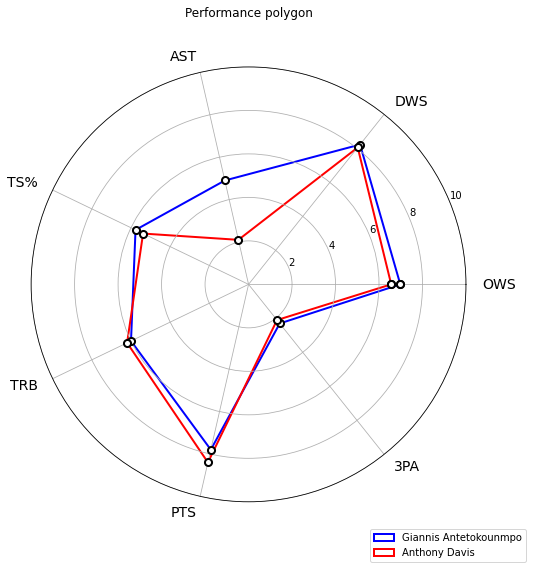

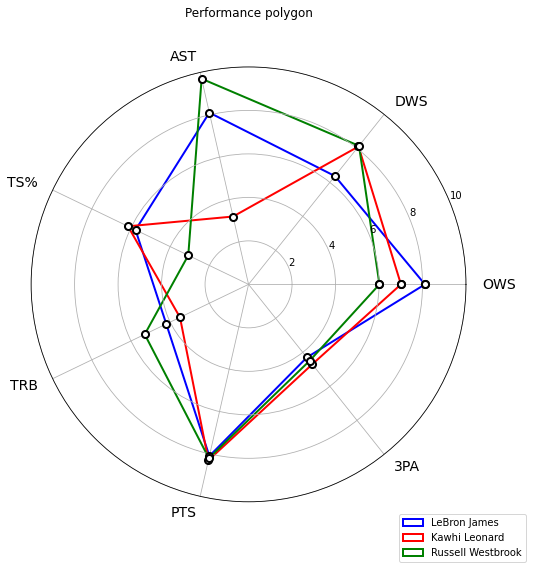

We clustered 5 players with DBSCAN in 2 clusters out of 336 players.


In [38]:
# ignore warnings for the polygone display
warnings.filterwarnings("ignore")

nb_of_cluster_DBSCAN_printed = 0
nb_of_players_clustered_with_DBSCAN = 0

#now let's print the overlapping polygones for each cluster
for i in dbscan_cluster.Cluster.unique():   
    players_to_draw = dbscan_cluster[dbscan_cluster["Cluster"] == i]["Player"].tolist()
    properties = ['OWS', 'DWS', 'AST','TS%', "TRB", "PTS", "3PA" ]
    if (len(players_to_draw) < 10):
        nb_of_cluster_DBSCAN_printed+=1
        nb_of_players_clustered_with_DBSCAN += len(players_to_draw)
        performance_polygon_vs_player(players_to_draw, properties)


print("We clustered "+str(nb_of_players_clustered_with_DBSCAN)+" players with DBSCAN in "+str(nb_of_cluster_DBSCAN_printed)+" clusters out of "+str(len(df.index))+" players.")

## Only 5 players clustered? Not very promising...

## Let's try Fuzzy Clustering

## Data retrieving

In [39]:
df = pd.read_csv('./csv/players_stats.csv')
player_names = df["Player"]

clustering_df = df.drop(columns=["Unnamed: 0","Player", "final_team","Pos"])

# we keep the interesting value
df_fcm = df[['Player', 'TRB', 'PTS', 'AST', "DWS", '3PA', "OWS", "USG%", "Height"]]

# we keep the players name for later
players_name = df_fcm["Player"]

# we remove the player column for the computation
df_fcm = df_fcm.loc[:,(df_fcm.columns != "Player")]

## Computation

In [40]:
# Computation
nb_cluster_fuzzy = 35
fuzzy_kmeans = FuzzyKMeans(k=nb_cluster_fuzzy, m=1.1)
fuzzy_kmeans.fit(df_fcm)
fuzzy_clusters = pd.DataFrame(fuzzy_kmeans.fuzzy_labels_)

# we add the players name back
fuzzy_clusters = pd.concat([players_name, fuzzy_clusters], axis=1)

## From Fuzzy clustering to hard clustering
## Let's group together the top n players of each clusters

In [41]:
nb_max_players_per_cluster_fcm = 3

final_clusters = pd.DataFrame()

for i in range(nb_cluster_fuzzy):
    # lets keep the coresponding col of membership degree
    sets = fuzzy_clusters[["Player", i]]
    
    # lets sort
    sets = sets.sort_values(by=i, ascending=False)
    
    #let's juste keep the top n% and be sure they are above a threeshold
    sets = sets.head(nb_max_players_per_cluster_fcm)
    sets = sets[["Player"]]
    
    # remove the hard clustered players from the fuzzy df to avoid having duplicates
    fuzzy_clusters = fuzzy_clusters[~fuzzy_clusters['Player'].isin(list(sets["Player"]))]
    
    #lets add the # of the cluster
    sets["Cluster"] = i+1
    #add those lines to the previous results
    final_clusters = pd.concat([final_clusters, sets], axis=0)


## Ploting the Fuzzy Clustering results

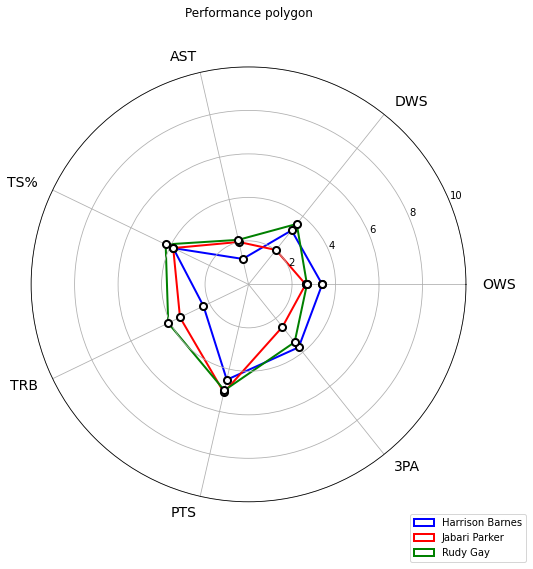

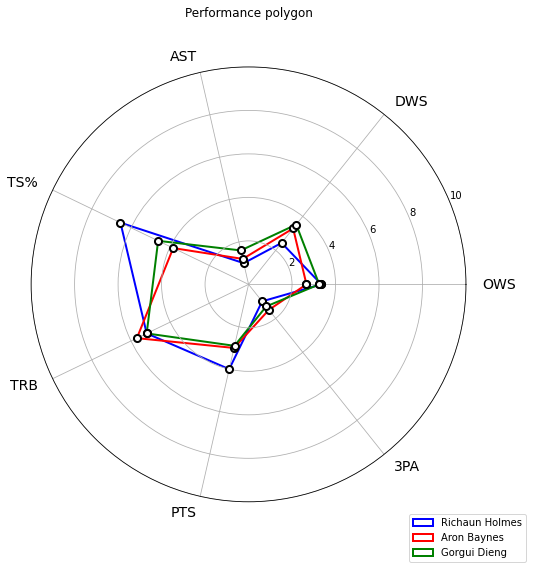

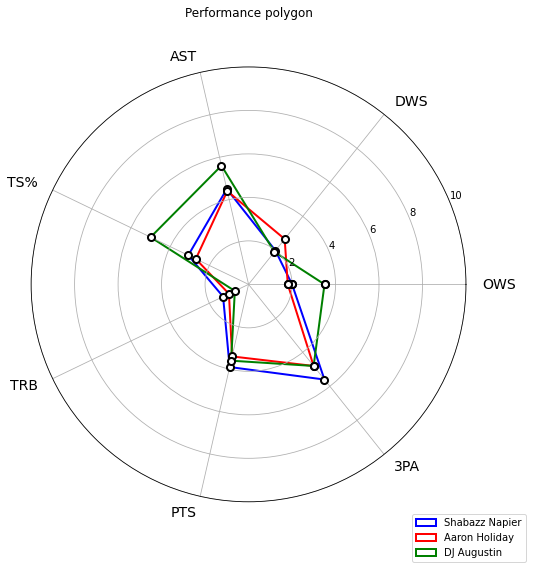

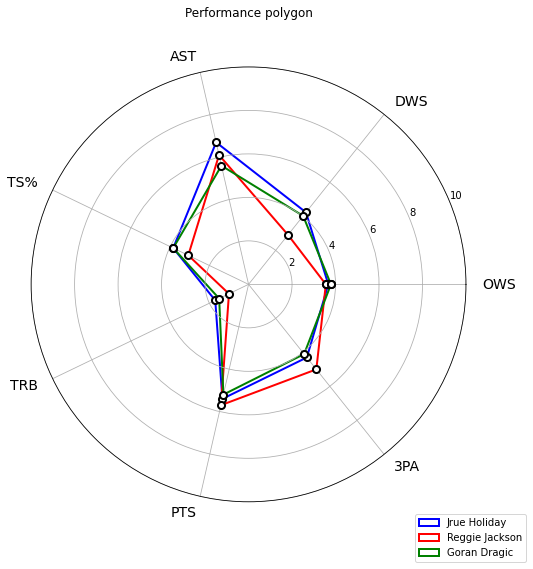

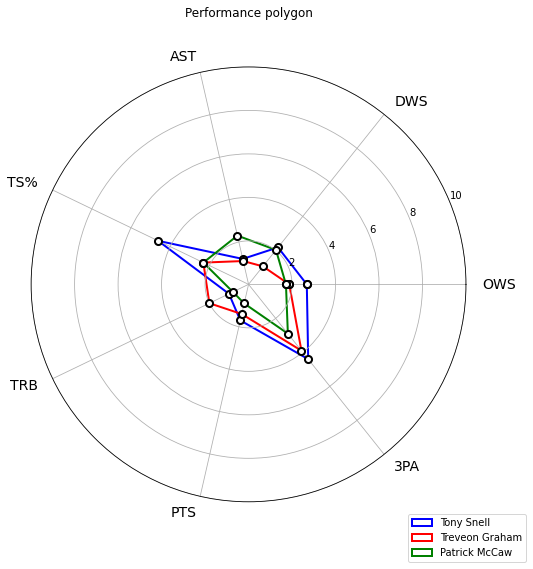

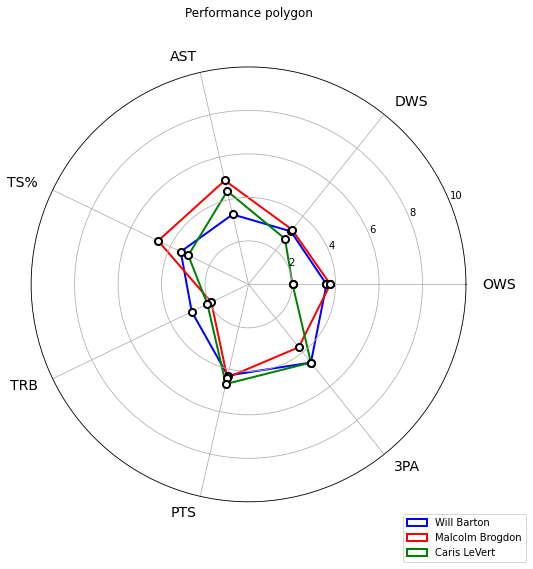

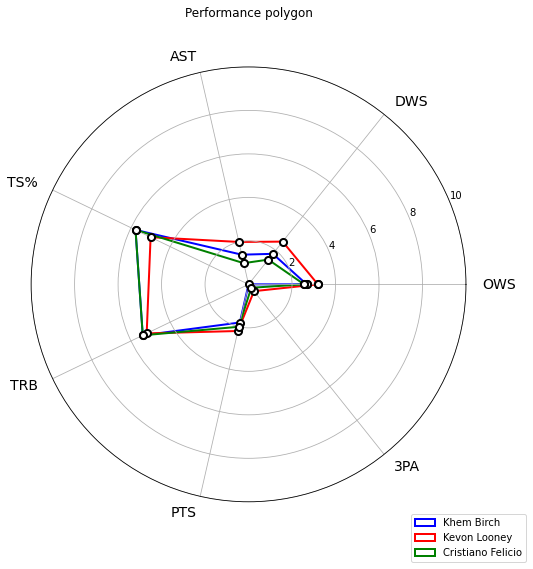

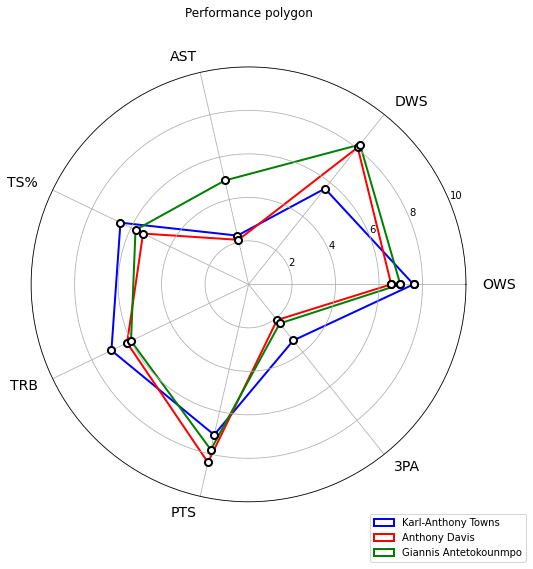

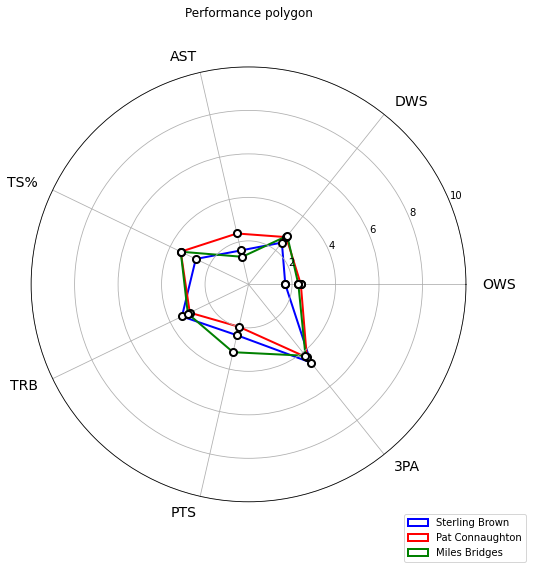

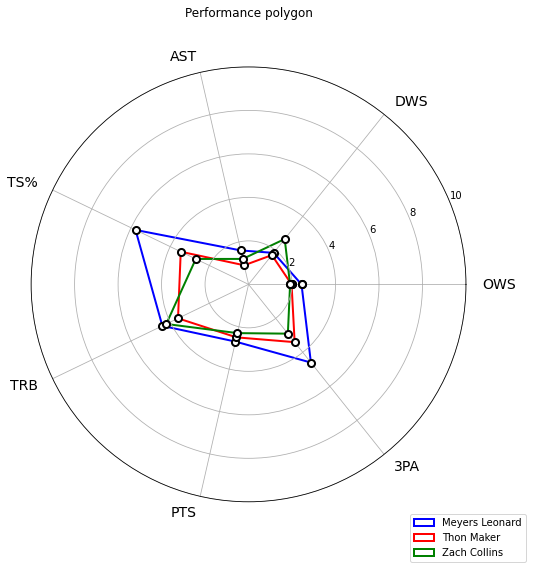

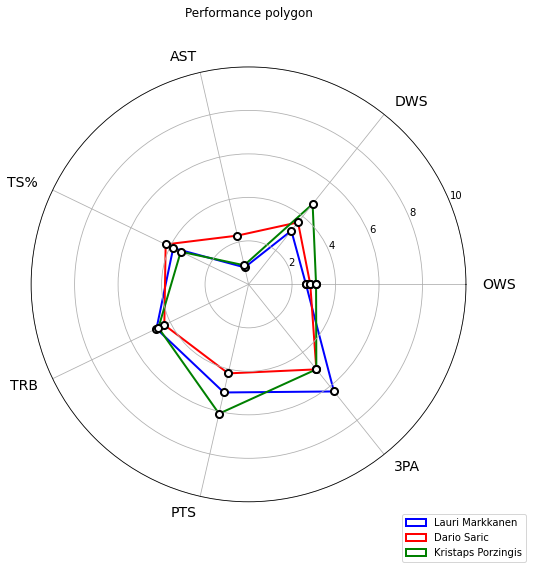

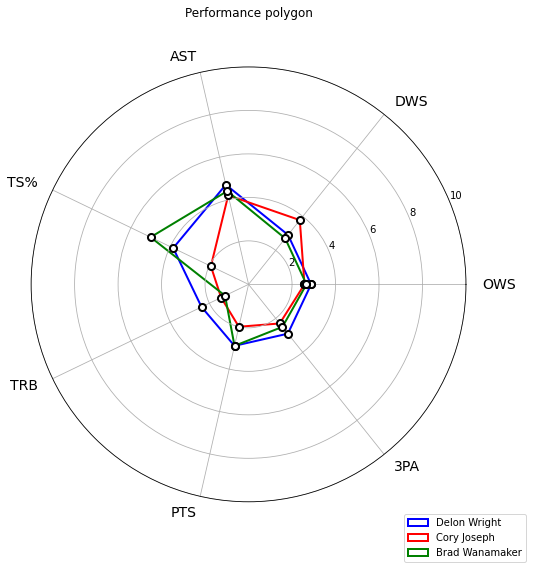

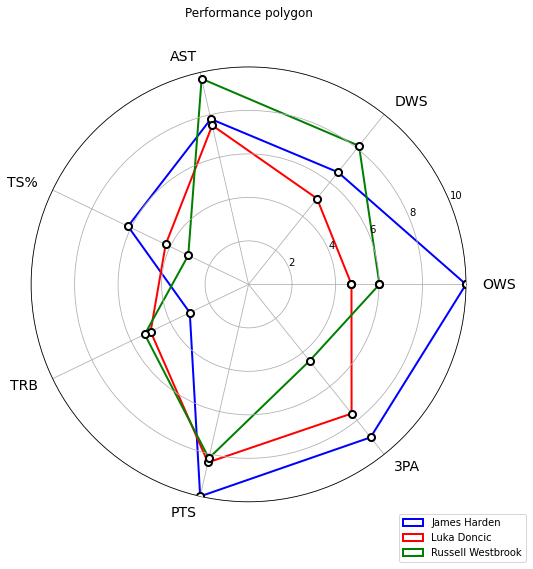

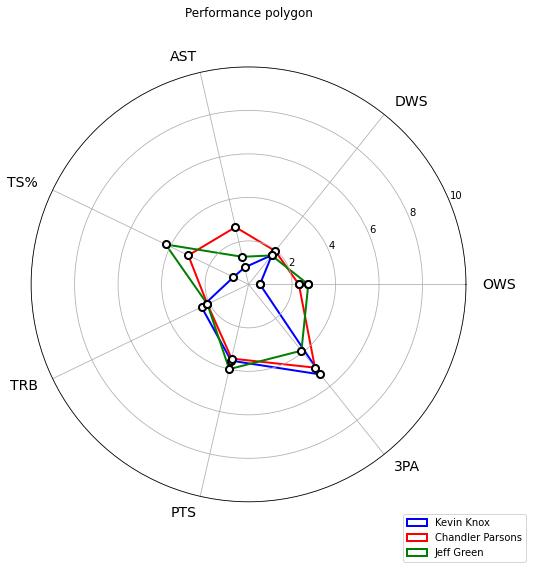

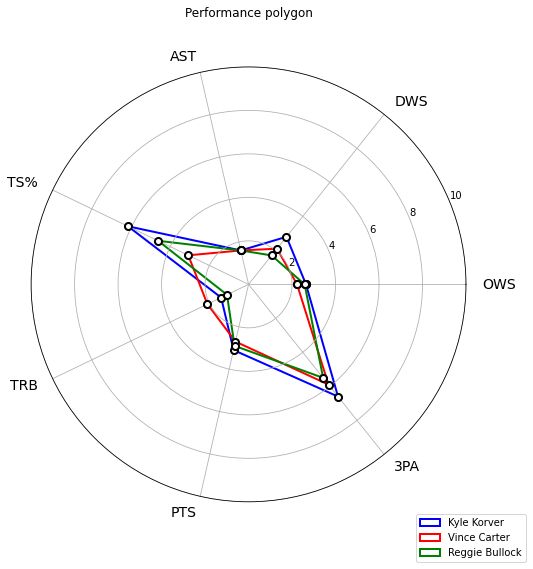

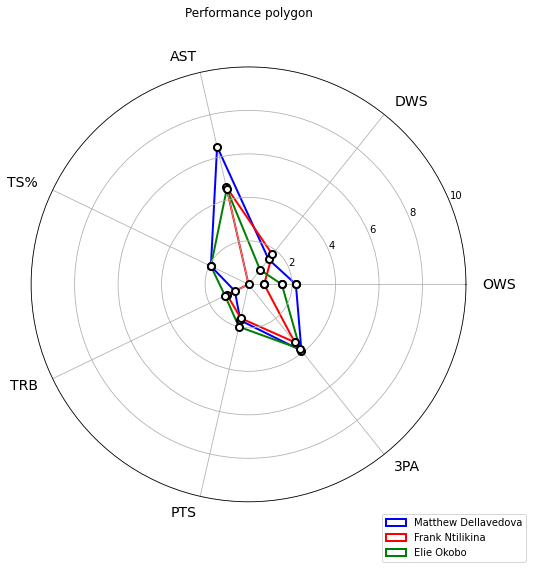

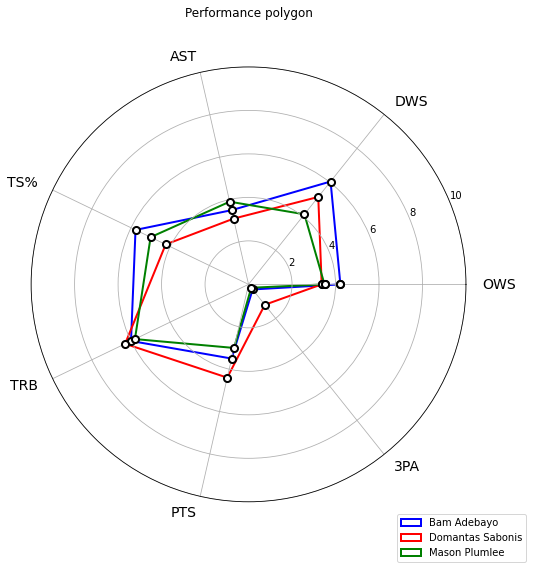

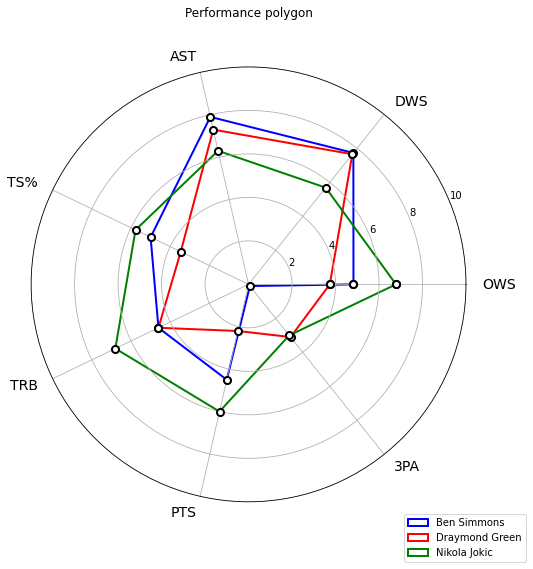

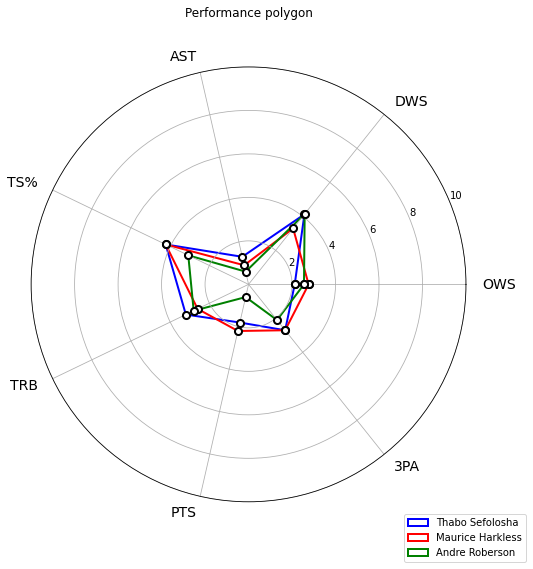

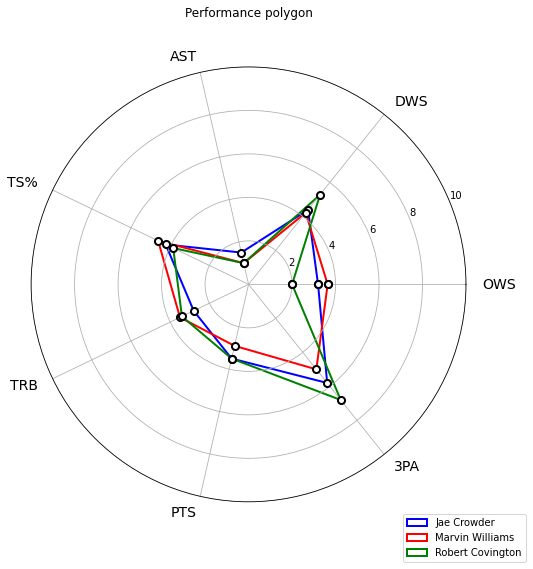

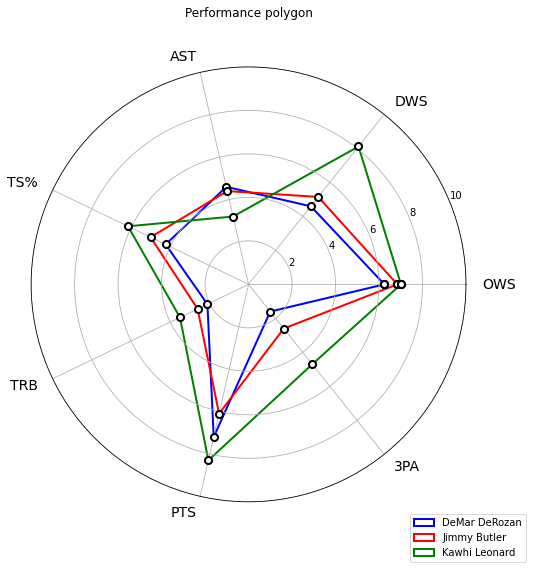

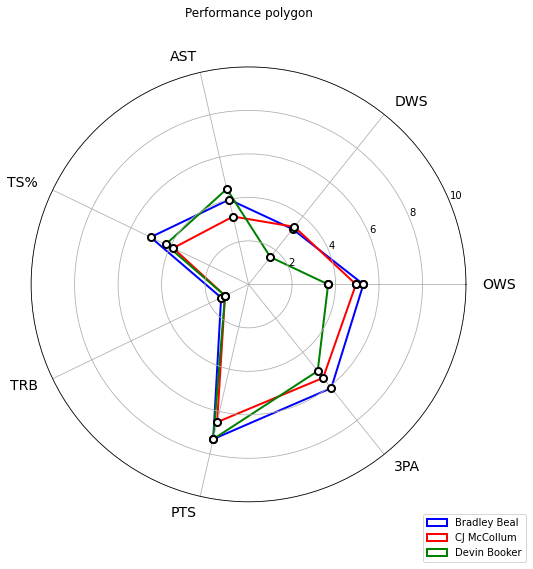

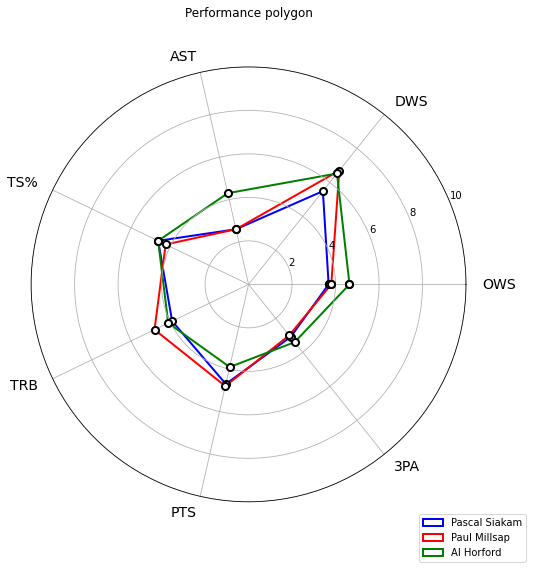

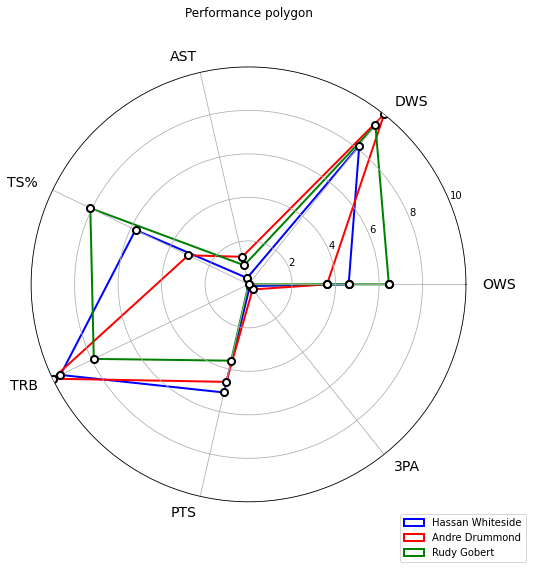

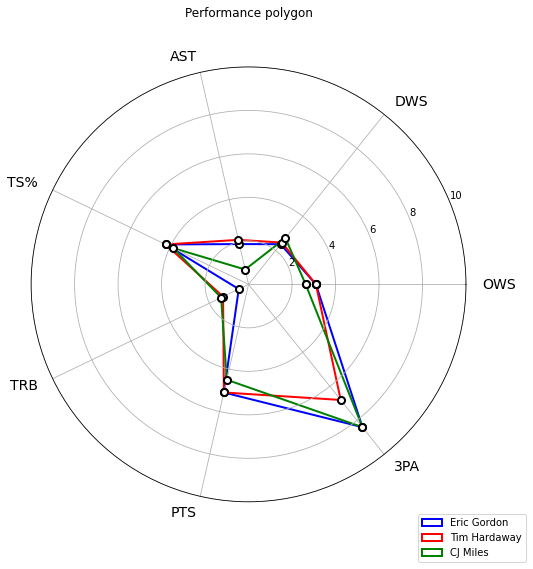

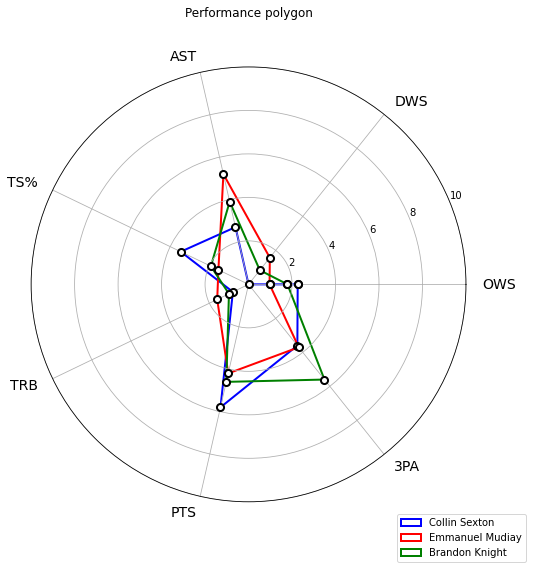

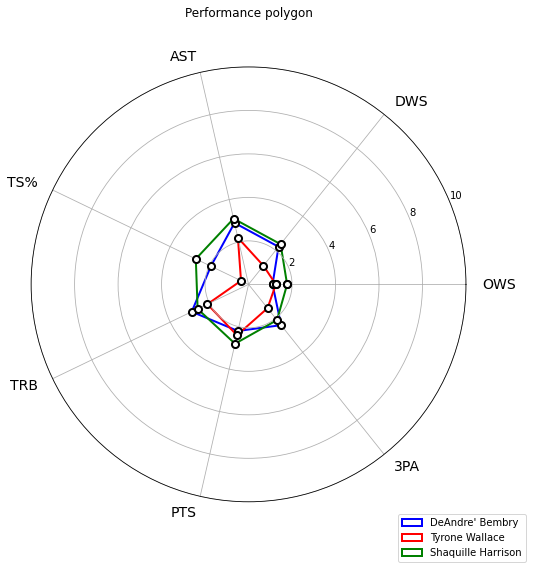

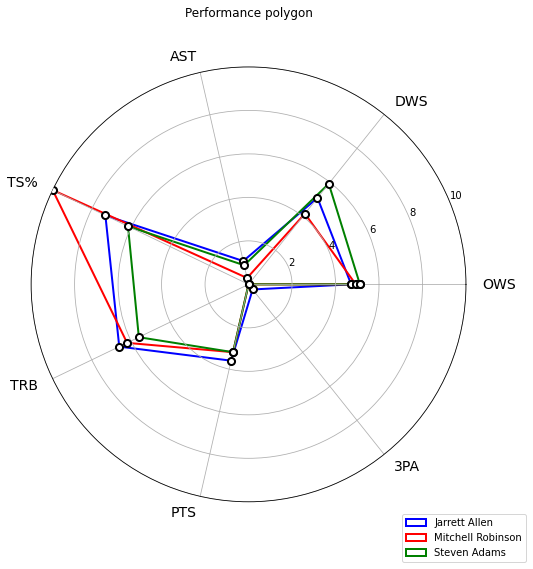

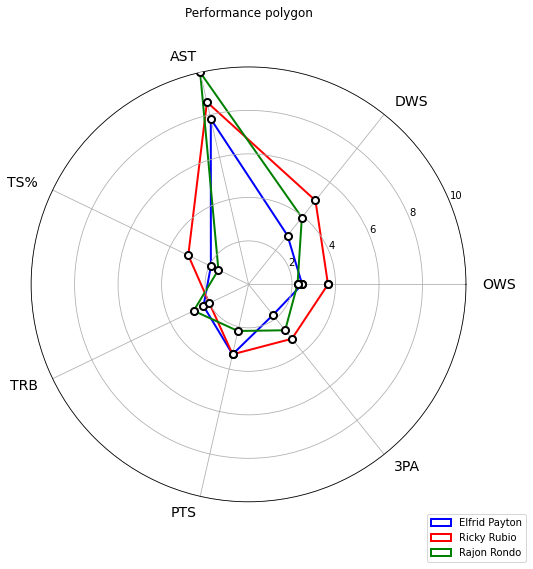

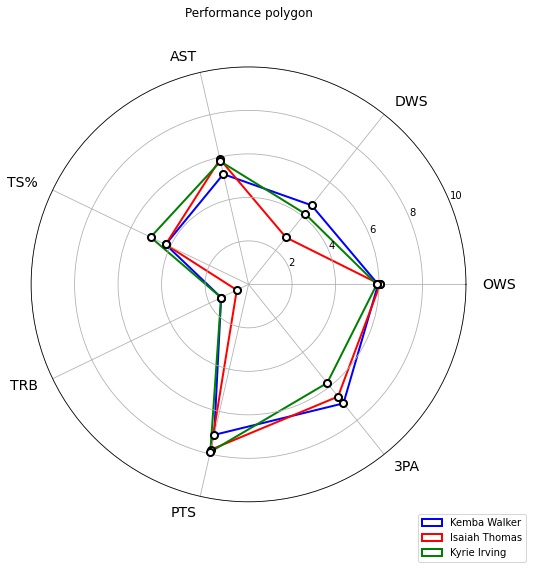

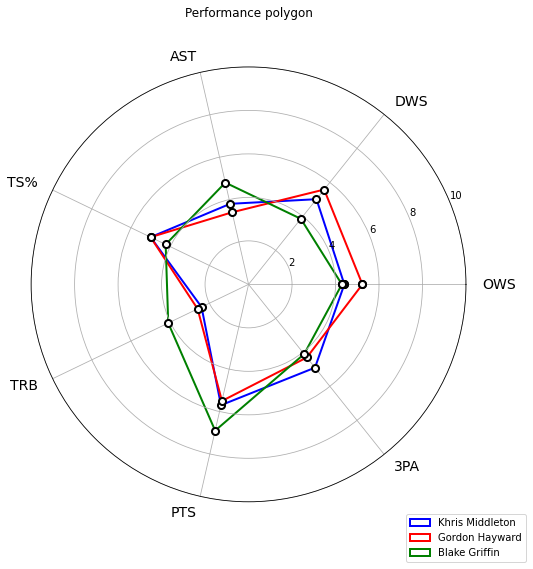

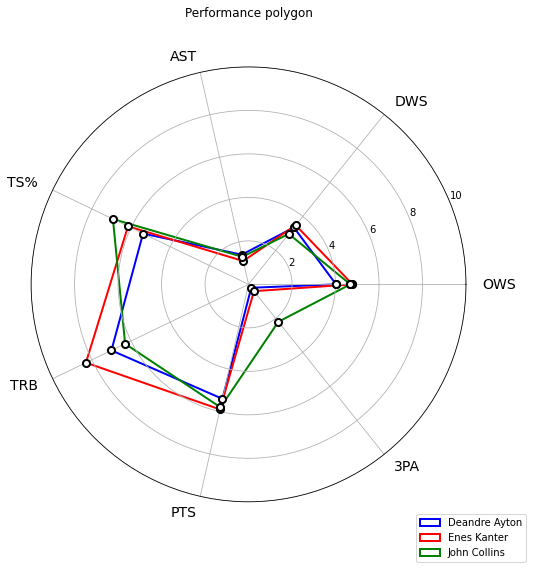

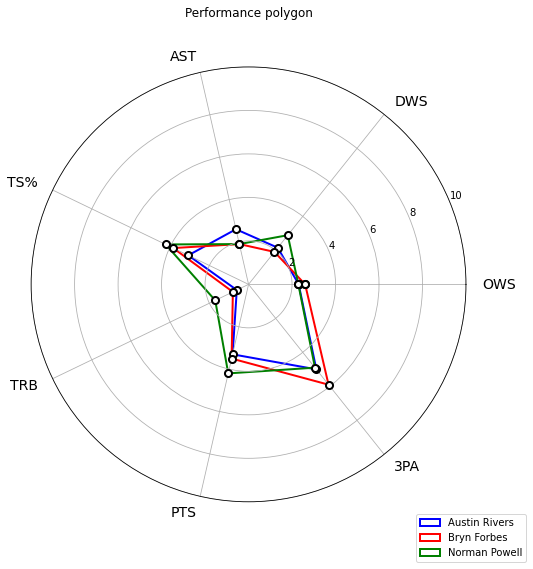

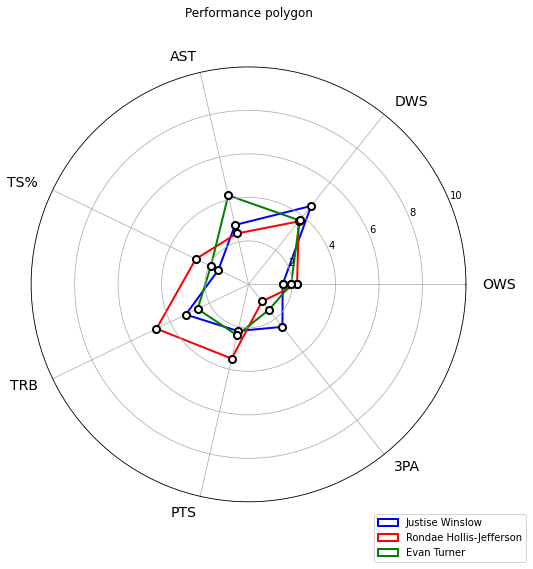

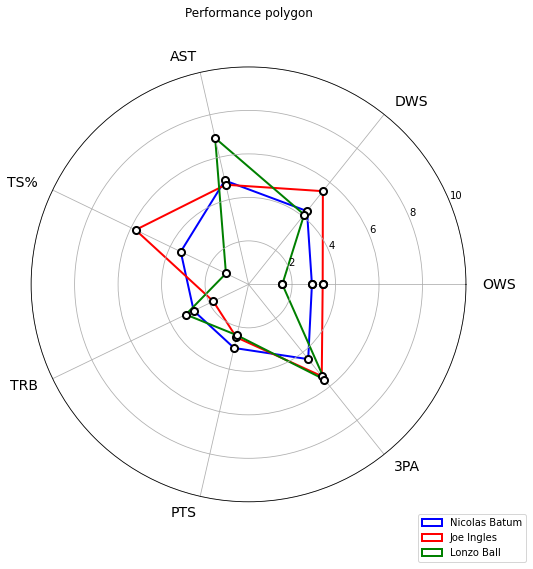

In [42]:
#now let's print the overlapping polygones for each cluster
for i in final_clusters.Cluster.unique():   
    players_to_draw = final_clusters[final_clusters["Cluster"] == i]["Player"].tolist()
    properties = ['OWS', 'DWS', 'AST','TS%', "TRB", "PTS", "3PA" ]
    performance_polygon_vs_player(players_to_draw, properties)

## Interesting but we are limited to a certain number of player (here 3*35 = 105)
## And we have to pick ourselves the number of clusters and the number of players per cluster

## Let's try with KMEANS since we need to categorize every player

In [43]:
# get the data
source = pd.read_csv('./csv/players_stats.csv')
df_to_compute = source.drop(columns=["Unnamed: 0","Player", "final_team","Pos"])

results = pd.DataFrame(data = None, columns = ['score'],dtype=np.float64) 

# computing the optimal number of cluster 
min_score_davies = 100000

max_score_silhouette = -100000

for nb_cluster_test in np.arange(start = 3,stop=100): 
            kmeans = KMeans(n_clusters=nb_cluster_test, random_state=0).fit(df_to_compute)
            score_davies = sklearn.metrics.davies_bouldin_score(df_to_compute,kmeans.labels_)
            score_silhouette = sklearn.metrics.silhouette_score(df_to_compute,kmeans.labels_)

            if (score_davies < min_score_davies):
                min_score_davies = score_davies
                optimal_number_of_cluster_davies = nb_cluster_test
            if (score_silhouette > max_score_silhouette):
                max_score_silhouette = score_silhouette
                optimal_number_of_cluster_silhouette = nb_cluster_test
                
optimal_number_of_cluster = int((optimal_number_of_cluster_davies + optimal_number_of_cluster_silhouette) / 2)

# compute K-MEANS
#nb_clusters = 70
kmeans = KMeans(n_clusters=optimal_number_of_cluster, random_state=0).fit(df_to_compute)

# average number of player per cluster
avg_number_per_cluster = round(len(df_to_compute.index) / optimal_number_of_cluster, 2)

# get the clusters
clusters = pd.DataFrame(kmeans.labels_)
clusters.columns = {"Cluster"}

# stick the cluster number for each player
clustered_players =pd.concat([clusters, source], axis=1)
clustered_players = clustered_players.drop(columns=["Unnamed: 0"])

# get the number of players in each cluster
stats = clustered_players[["Cluster", "PTS"]].groupby(["Cluster"]).agg(["count"])

## Once again we are still face to the issue of the number of cluster
## Both methods (silhouette and Davies) rewards either the min or the max number of cluster among the values we are testing

## Let's try to use another approach: Dissimilarity Matrix

In [44]:
def computing_distance_matrix(source, criterias):    
    player_names = source["Player"]
    
    # we keep the interesting value
    df = source[criterias]
    
    # number of player
    nb_of_players = len(df.index)
    
    # our distance matrix
    dist_mat_dict = {}
    
    #lets compute the distance for every couple of players
    for i in range(nb_of_players):
        dist_mat_dict[player_names[i]] = {}
        for j in range(nb_of_players):
            dist_mat_dict[player_names[i]][player_names[j]] = round(distance.euclidean(df.iloc[i], df.iloc[j]), 3)
    
    
    # list is more convenient for scaling
    # here we have a list of lists
    distance_matrix_list = [list(z.values()) for y,z in dist_mat_dict.items()]
    distance_matrix_list = pd.DataFrame(distance_matrix_list)
    min_of_distance = distance_matrix_list.min().min()
    max_of_distance = distance_matrix_list.max().max()
    
        
    # we fill back the value from the list to the dict
    for i in range(nb_of_players):
        for j in range(nb_of_players):
            
            # scaling before
            distance_matrix_list[i][j] = distance_matrix_list[i][j] - min_of_distance
            distance_matrix_list[i][j] = distance_matrix_list[i][j] / (max_of_distance - min_of_distance)
            
            # in order to have a 0-100% confidence index
            # let's do the 1 complement value and multiple by 100
            # with two digits after the coma
            val = round(abs(1 - distance_matrix_list[i][j])*100, 2)
            dist_mat_dict[player_names[i]][player_names[j]] = val
    
    # lets save it so we do not have to compute everytime
    dist_mat_df = pd.DataFrame(dist_mat_dict)
    dist_mat_df.to_csv("./csv/distance_matrix.csv")



## get the distance between several players

In [45]:
# return a dict of dict
def get_distance_between_players(list_of_players, dist_matrix):
    #lets sort it to have the same order on both axis
    list_of_players = sorted(list_of_players)
    dist_mat_dict = {}
    for player in list_of_players:
        dist_mat_dict[player] = {}
        for player2 in list_of_players:
            dist_mat_dict[player][player2] = dist_matrix[dist_matrix["Name"] == player].iloc[0][player2]
            
    return dist_mat_dict

## get the n most similar to a player

In [46]:
#return a list of 2-elements tuples (name, similarity score)
def get_most_similar_players(player_name, nb_of_similar_players_wanted, dist_mat):
    
    #lets sort the list of similarity between player and the rest of the NBA
    sorted_similarity = dict(sorted(dist_mat[player_name].items(), key=lambda item: item[1], reverse=True))

    #lets keep the n first (Except the the closest who is the player himself)
    most_similar_players = list(sorted_similarity.items())[1:nb_of_similar_players_wanted+1]
    
    # retrieve the players name instead of his index number
    for i in range(len(most_similar_players)):
        index_value = most_similar_players[i][0]
        name = dist_mat["Name"][index_value]
        similarity_confidence = most_similar_players[i][1]
        most_similar_players[i] = (name,similarity_confidence)
                
    return most_similar_players

## Plot the heat Matrix of a list of players

In [47]:
def plot_heat_matrix(only_number_matrix, list_of_players):
    #lets try to plot a heat matrix
    c = plt.imshow(only_number_matrix, cmap='Reds', interpolation='nearest')
    plt.title("Similarity of players")
    plt.colorbar(c)
    # rotate to prevent players name from overlapping
    plt.xticks(np.arange(0, len(list_of_players)) , list_of_players, rotation=270)
    plt.yticks(np.arange(0, len(list_of_players)) , list_of_players)
    plt.show()

## Example of use

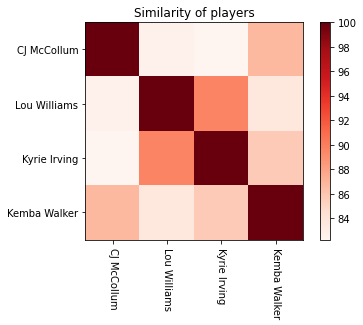

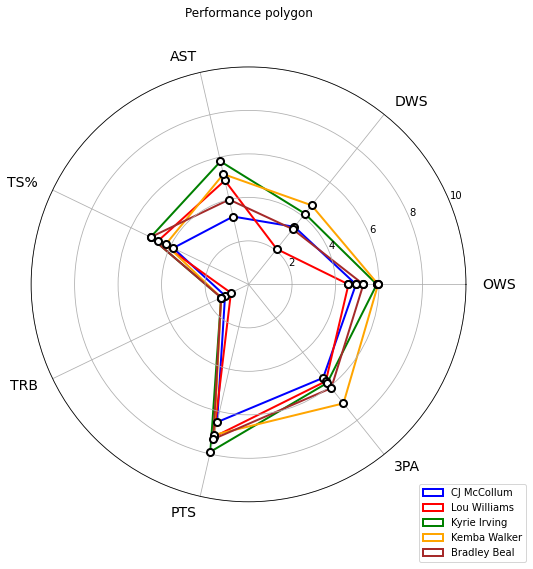

In [48]:
source = pd.read_csv('./csv/players_stats.csv')
criterias = ['TRB', 'PTS', 'AST', 'DWS', '3PA', "OWS", "USG%", "Height"]

computing_distance_matrix(source, criterias)

#retrieving the data
dist_mat = pd.read_csv("./csv/distance_matrix.csv")        
dist_mat = dist_mat.rename(columns={"Unnamed: 0": 'Name'})

# get the n most similar player to X and get the similarity values between each and every one of them
player = "Bradley Beal"
most_similar_players = get_most_similar_players(player, 4, dist_mat)
most_similar_players_names = [names for (names, score) in most_similar_players ]

players_distances = get_distance_between_players(most_similar_players_names, dist_mat)
only_number_matrix = [list(value.values()) for key, value in players_distances.items()]

# plot the heat matrix of several players
plot_heat_matrix(only_number_matrix, most_similar_players_names)

# draw polygones
players_to_draw = [player[0] for player in most_similar_players]
players_to_draw.append(player)
properties = ['OWS', 'DWS', 'AST','TS%', "TRB", "PTS", "3PA" ]
performance_polygon_vs_player(players_to_draw, properties)

In [49]:
print("--- %s seconds --- to execute the notebook" % round(time.time() - start_time, 2))

--- 99.49 seconds --- to execute the notebook
